## Credit Fraud Detection

Objective: To build a machine learning model to identify fraudulent credit card transactions.

### Steps Taken

1. Data Collection and preprocessing
2. Exploratory Data Analysis
3. Model Implementation

### 1. Data Collection and preprocessing

Data used for project: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

About data: The dataset contains transactions made by credit cards in September 2013 by European cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
pip install -U imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/92/e8/86c36e1b13007ca9c89381adac6c078cfc8fb71841a76c08a3fe3eca91d3/imbalanced_learn-0.12.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 3.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/45/6d/8c1d2570a52db6263d855c3ee3daf8f4bdf4a365cd6610772d6fce5fd904/xgboost-2.0.3-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
# import necessary libraries
# importing necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# importing models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from xgboost import XGBClassifier

# libaries for under sampling 
from imblearn.under_sampling import RandomUnderSampler


# importing evaluation metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import joblib

In [6]:
# load dataset
credit_card_df=pd.read_csv('creditcard.csv')
credit_card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# check the size of the dataset
credit_card_df.shape

(284807, 31)

In [8]:
# get the  dataset info
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
# check for null values in the data
credit_card_df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
# check for any duplicate data in the dataset
credit_card_df.duplicated().any()

True

In [11]:
# drop duplicates data
credit_card_df=credit_card_df.drop_duplicates()

In [12]:
credit_card_df['Amount']

0         149.62
1           2.69
2         378.66
3         123.50
4          69.99
           ...  
284802      0.77
284803     24.79
284804     67.88
284805     10.00
284806    217.00
Name: Amount, Length: 283726, dtype: float64

In [13]:
# Normalising the data
# All the feature from v1-v28 are already in normalised form only amount needs to be normalised
# using StandardScaler to normalise the amount feature

scaler=StandardScaler()
credit_card_df['Amount']=scaler.fit_transform(pd.DataFrame(credit_card_df['Amount']))

In [14]:
credit_card_df['Amount']

0         0.244200
1        -0.342584
2         1.158900
3         0.139886
4        -0.073813
            ...   
284802   -0.350252
284803   -0.254325
284804   -0.082239
284805   -0.313391
284806    0.513290
Name: Amount, Length: 283726, dtype: float64

### 2. Exploratory Data Analysis

<Axes: >

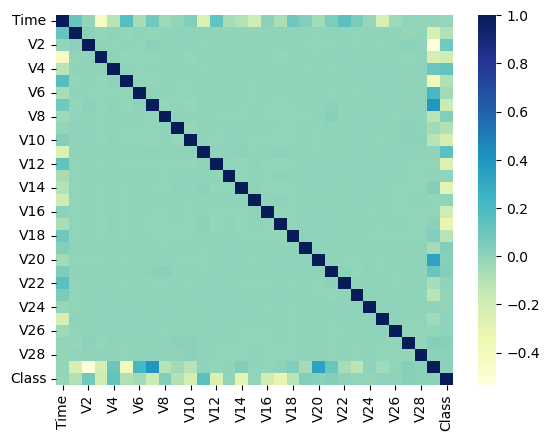

In [15]:
# Correlation heatmap
sns.heatmap(credit_card_df.corr(), cmap='YlGnBu', annot=False)

In [16]:
# let's check for traget variable
credit_card_df['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

<Axes: xlabel='Class'>

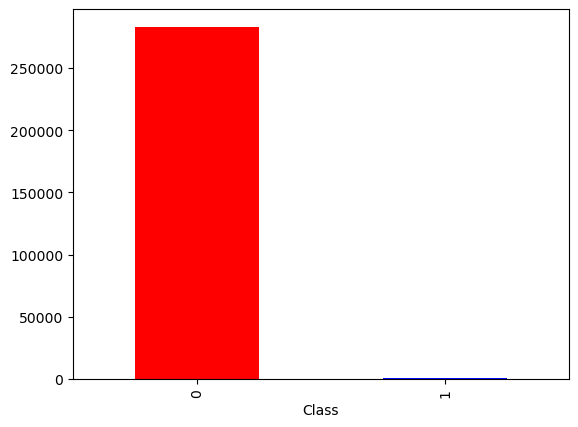

In [17]:
credit_card_df['Class'].value_counts().plot(kind='bar', color=['red','blue'])

It seems there is a class imbalance problem in the target variable where the fraud which is 1 which is very low in number as compare to non fraudulent transaction. To solve the class imbalance problem I am going to use random Under-sampling which is removing some data from non-fraudulent util it is balance with the fraudulent transaction data.

### Random Under Sampling

In [18]:
# splitting the data into X and y
X=credit_card_df.drop('Class', axis=1)
y=credit_card_df['Class']

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# random under-sampling
rus=RandomUnderSampler(random_state=42, replacement=True)
x_rus,y_rus=rus.fit_resample(X_train,y_train)

x_rus.shape

(678, 30)

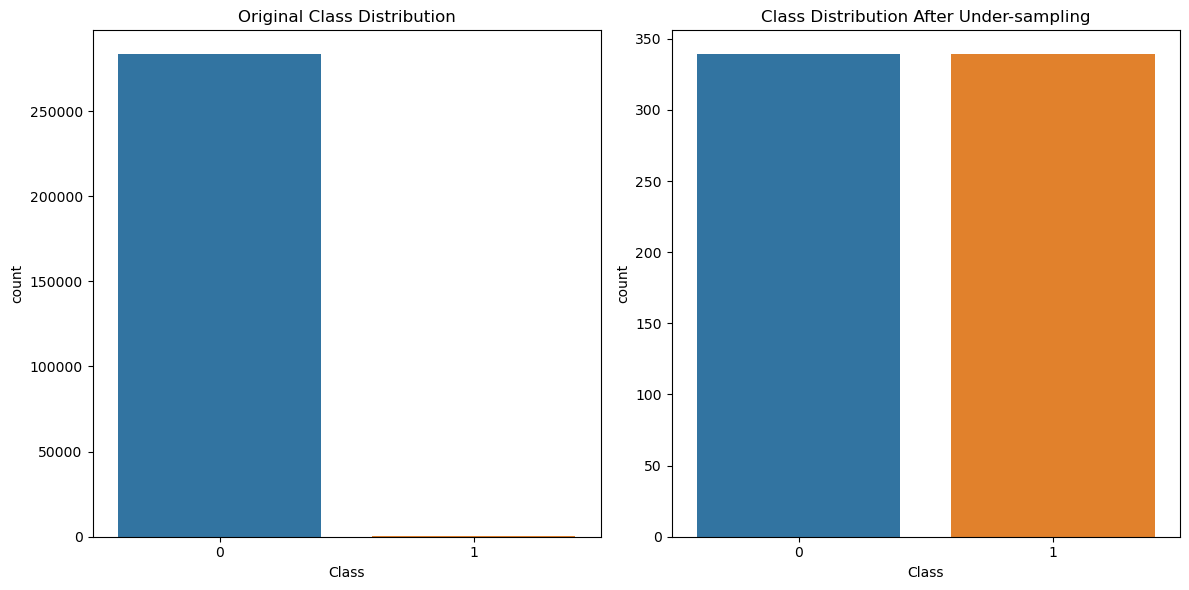

In [21]:
# Visualize class distribution before and after sampling
plt.figure(figsize=(12, 6))

# Plot original class distribution
plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title("Original Class Distribution")

# Plot class distribution after SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_rus)
plt.title("Class Distribution After Under-sampling")

plt.tight_layout()
plt.show()

### 3. Model Implementation

In [22]:
models={'Logistic Regression':LogisticRegression(),
        'Random Forest Classifier':RandomForestClassifier(),
       'Support Vector Machine':SVC(),
       'XGBoost':XGBClassifier()}

In [23]:
models

{'Logistic Regression': LogisticRegression(),
 'Random Forest Classifier': RandomForestClassifier(),
 'Support Vector Machine': SVC(),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)}

In [24]:
# create a function to fit and score models
def fit_and_score(models, X_train,X_test, y_train, y_test):
    # set random seed
    np.random.seed(42)
    #make a dictionary to keep model scores
    model_scores=[]
    #Loop through models
    for name,model in models.items():
        # Fit the model
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        
#         Plotting confusion matrix
        labels=['Normal', 'Fraud']
        conf_matrix=confusion_matrix(y_test,y_pred)
        
        plt.figure(figsize=(12, 12))
        sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap="Oranges")  # You can change "Blues" to another colormap
        plt.title(f"Confusion Matrix for {name}")
        plt.ylabel('True class')
        plt.xlabel('Predicted class')
        plt.show()
        
        #Evaluate the model and append its score
        print(f"Evaluating {name}....")
        report_dict=classification_report(y_test,y_pred, output_dict=True)
        
                # Extract relevant metrics from the classification report
        precision_0 = report_dict['0']['precision']
        recall_0 = report_dict['0']['recall']
        f1_0 = report_dict['0']['f1-score']
        
        precision_1 = report_dict['1']['precision']
        recall_1 = report_dict['1']['recall']
        f1_1 = report_dict['1']['f1-score']

        model_scores.append({
            'Model': name,
            'Precision_0': precision_0,
            'Recall_0': recall_0,
            'F1_0': f1_0,
            'Precision_1': precision_1,
            'Recall_1': recall_1,
            'F1_1': f1_1
        })
        
    model_scores=pd.DataFrame(model_scores)
    return model_scores

/Users/jaycemoody/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


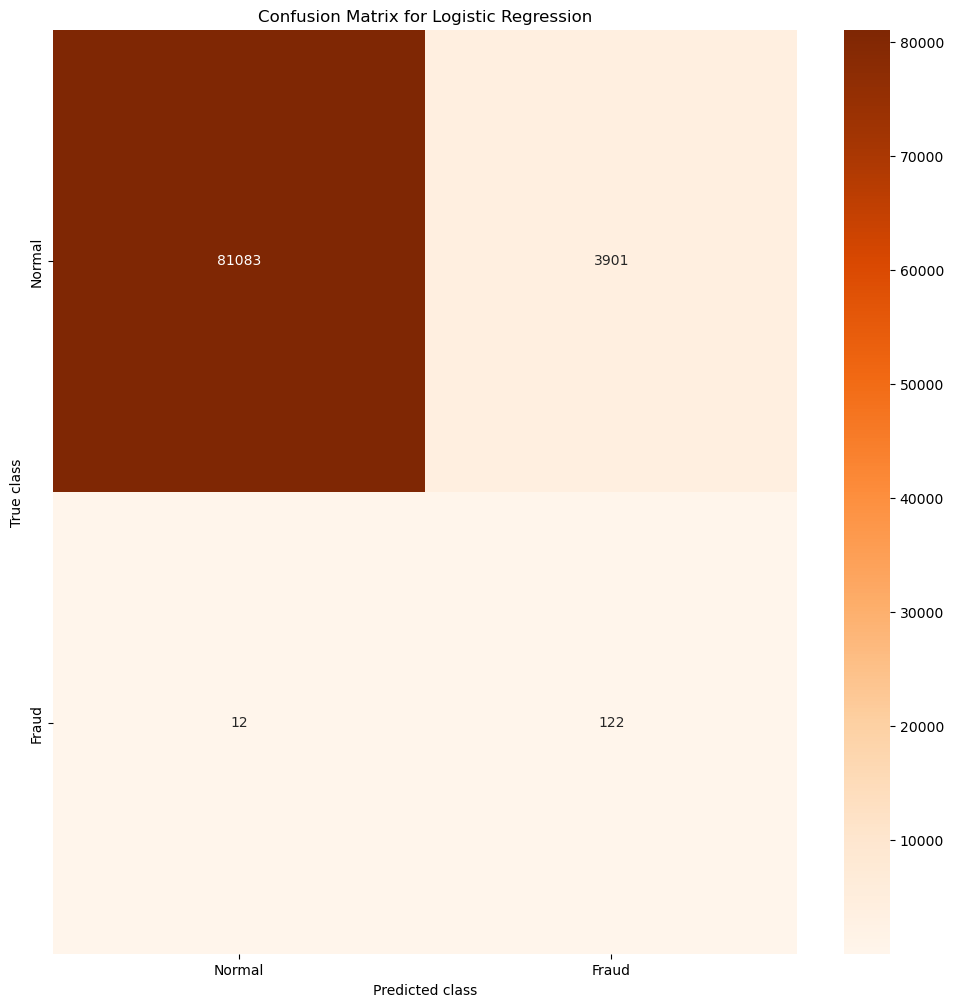

Evaluating Logistic Regression....


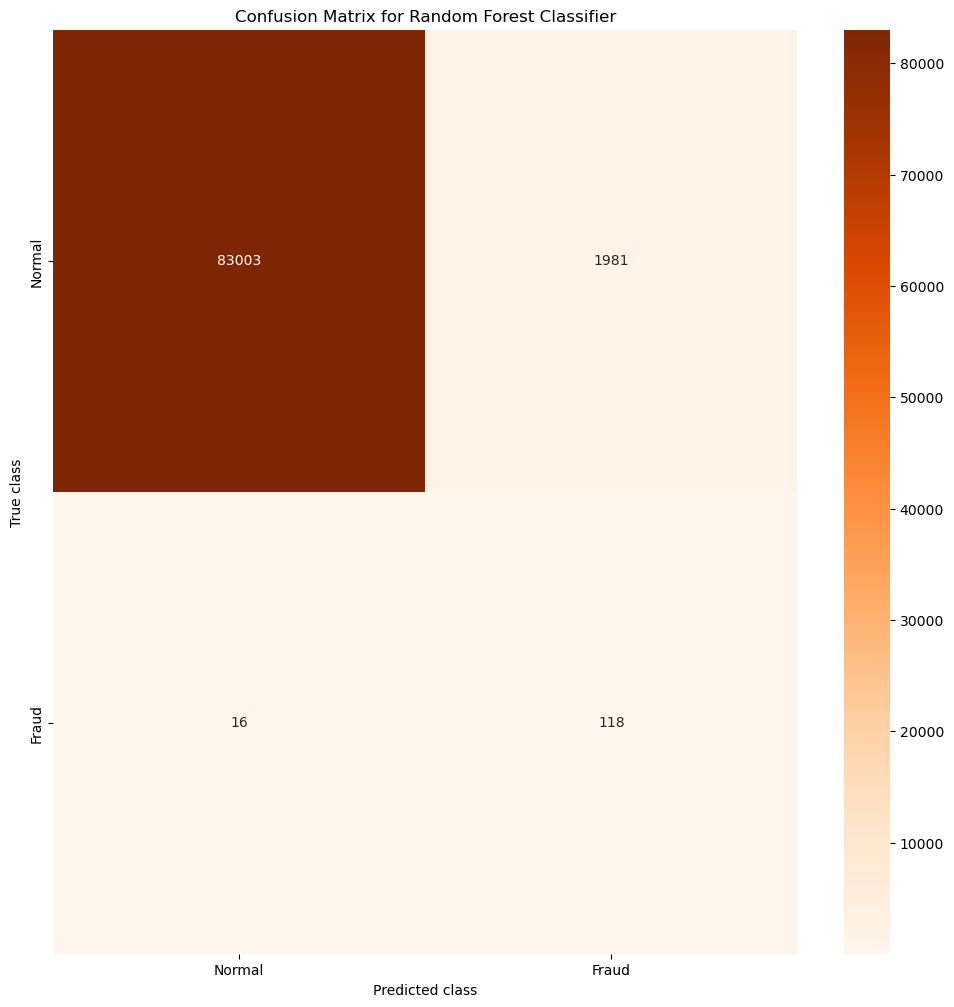

Evaluating Random Forest Classifier....


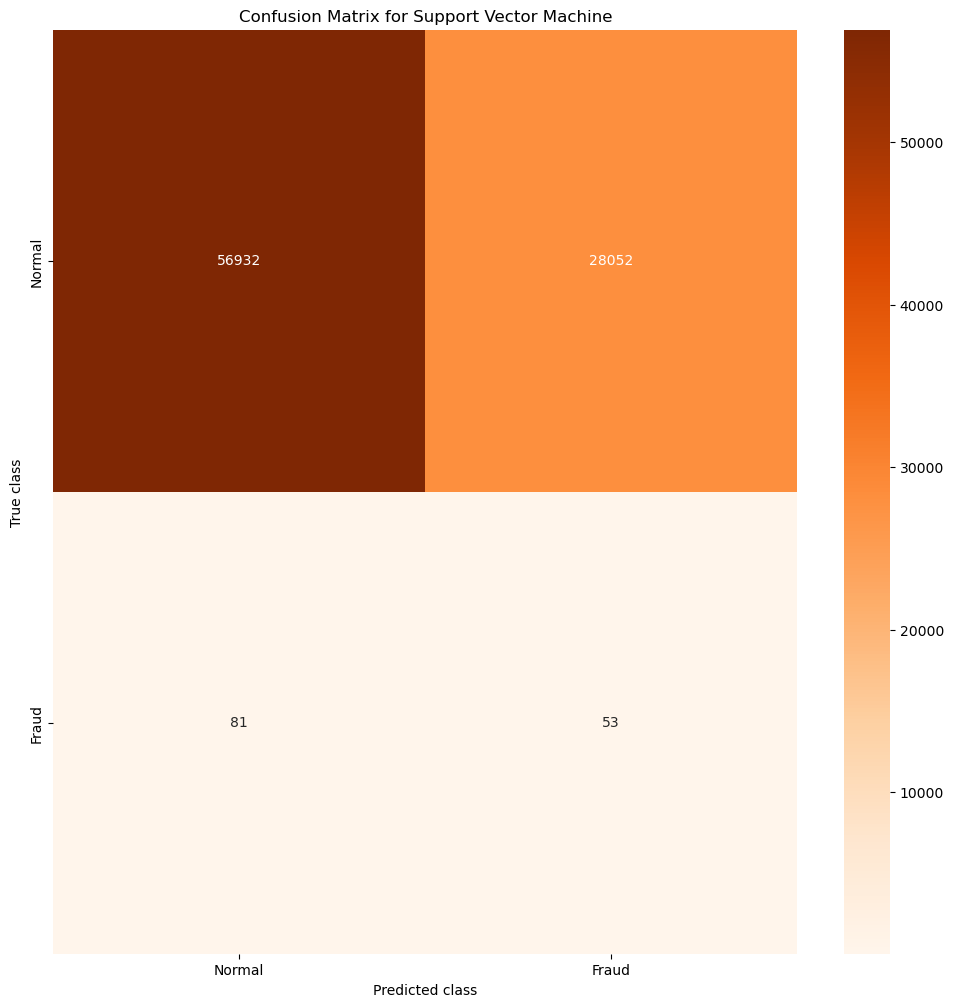

Evaluating Support Vector Machine....


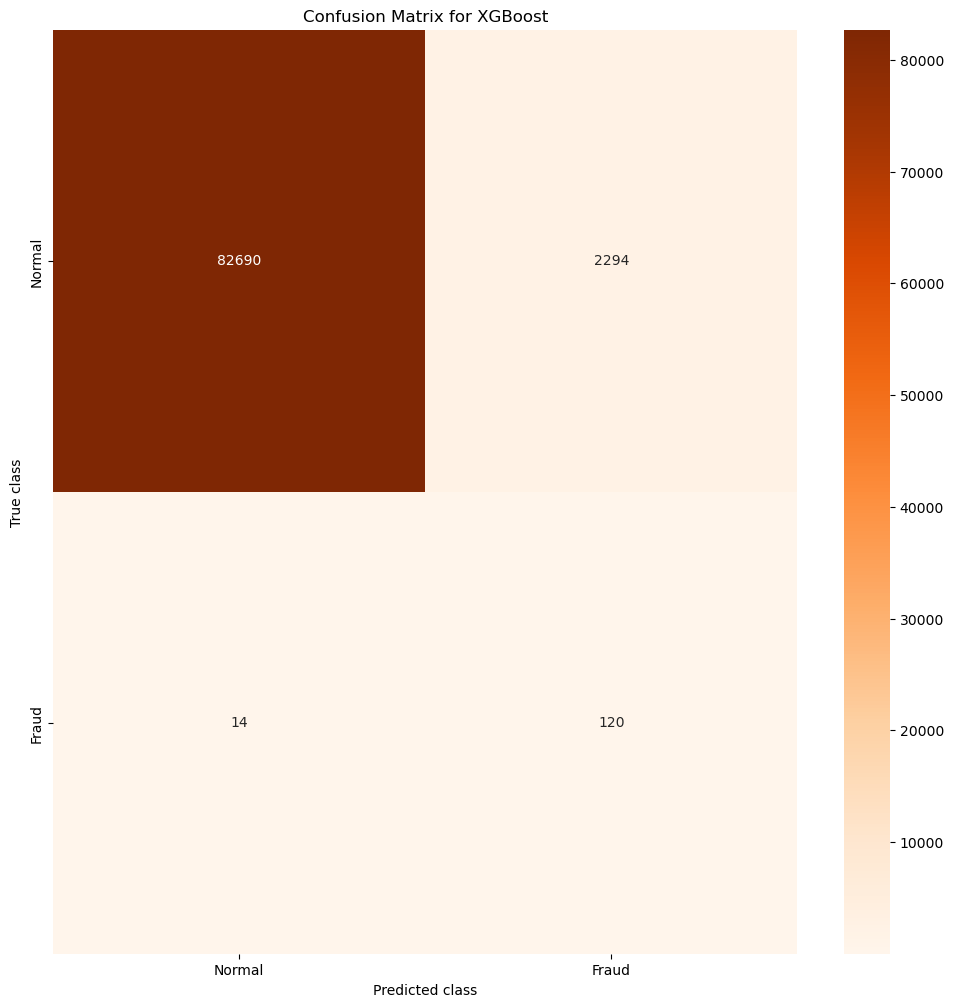

Evaluating XGBoost....


,Model,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
0,Logistic Regression,0.999852,0.954097,0.976439,0.030326,0.910448,0.058696
1,Random Forest Classifier,0.999807,0.976690,0.988113,0.056217,0.880597,0.105687
2,Support Vector Machine,0.998579,0.669914,0.801876,0.001886,0.395522,0.003754
3,XGBoost,0.999831,0.973007,0.986236,0.049710,0.895522,0.094192


In [25]:
model_scores=fit_and_score(models=models, X_train=x_rus,X_test=X_test,y_train=y_rus ,y_test=y_test)
model_scores

In [26]:
model_scores

,Model,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
0,Logistic Regression,0.999852,0.954097,0.976439,0.030326,0.910448,0.058696
1,Random Forest Classifier,0.999807,0.976690,0.988113,0.056217,0.880597,0.105687
2,Support Vector Machine,0.998579,0.669914,0.801876,0.001886,0.395522,0.003754
3,XGBoost,0.999831,0.973007,0.986236,0.049710,0.895522,0.094192


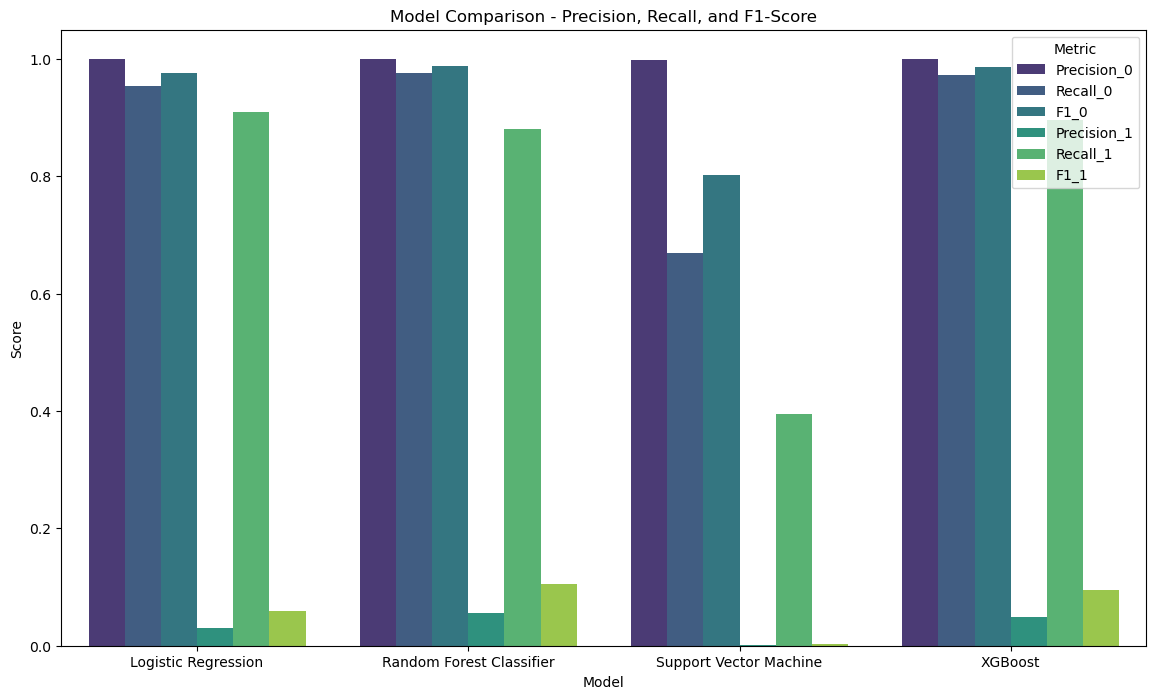

In [27]:
# plot the results
# Melt the DataFrame to make it suitable for plotting
df_melted = pd.melt(model_scores, id_vars=['Model'], var_name='Metric', value_name='Score')

# Plotting using seaborn
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, palette='viridis')
plt.title('Model Comparison - Precision, Recall, and F1-Score')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()